<a href="https://colab.research.google.com/github/Maspie/-Assignment/blob/main/Snakes_on_OTSU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-b6239ed558b4>:25: RuntimeWarning: invalid value encountered in divide
  between_class_variance = (total_mean * cumulative_sum - cumulative_mean) ** 2 / (cumulative_sum * (1 - cumulative_sum))


Optimal Threshold: 143


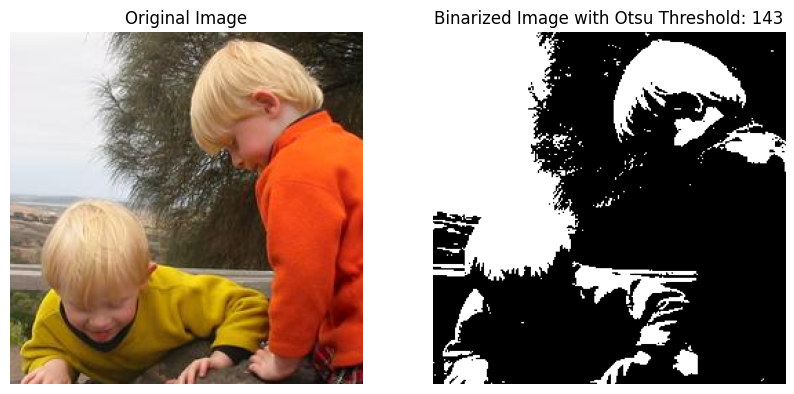

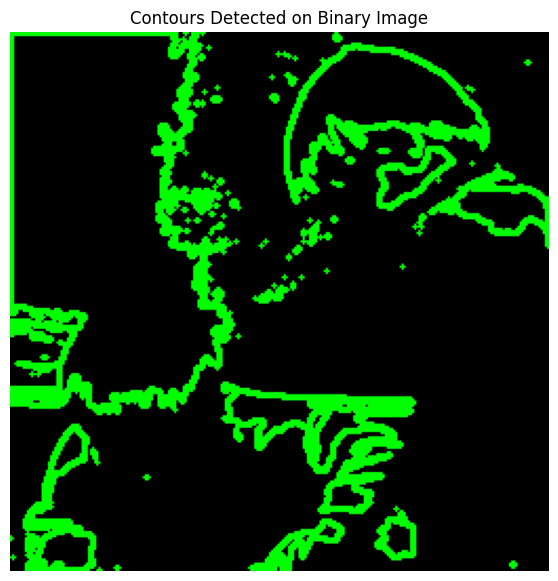

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# Otsu's thresholding function
def otsu_thresholding(image):
    # Calculate histogram
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])

    # Normalize histogram
    hist = hist / hist.sum()

    # Cumulative sum of histogram
    cumulative_sum = np.cumsum(hist)

    # Cumulative mean of histogram
    cumulative_mean = np.cumsum(hist * np.arange(256))

    # Total mean of the histogram
    total_mean = cumulative_mean[-1]

    # Compute between-class variance
    between_class_variance = (total_mean * cumulative_sum - cumulative_mean) ** 2 / (cumulative_sum * (1 - cumulative_sum))

    # Ignore nan values
    between_class_variance = np.nan_to_num(between_class_variance)

    # Find the threshold that maximizes the between-class variance
    optimal_threshold = np.argmax(between_class_variance)

    return optimal_threshold

def apply_threshold(image, threshold):
    # Apply the threshold to the image
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

# Load the uploaded image
image_path = '/content/twins.tif'
image = cv2.imread(image_path)  # Read the image in color (BGR)

# Check if the image was loaded successfully
if image is None:
    print("Error: Image not found or could not be loaded.")
else:
    # Convert to grayscale for Otsu's thresholding
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform Otsu's thresholding on the grayscale image
    optimal_threshold = otsu_thresholding(gray_image)
    print(f'Optimal Threshold: {optimal_threshold}')

    # Apply the threshold to the grayscale image
    binary_image = apply_threshold(gray_image, optimal_threshold)

    # Display the original and binarized image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_image, cmap='gray', vmin=0, vmax=255)  # Ensure display as black and white
    plt.title(f'Binarized Image with Otsu Threshold: {optimal_threshold}')
    plt.axis('off')
    plt.show()

    # Find contours on the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a copy of the original image
    contour_image = np.zeros_like(image)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Green contours

    # Display the contours on the original image
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.title('Contours Detected on Binary Image')
    plt.axis('off')
    plt.show()

    init = np.array([[r, c] for r in range(50, 250) for c in range(50, 250)])  # Adjust initialization as needed

    # Apply the active contour model to the binary image
    snake = active_contour(
        gaussian(binary_image.astype(np.float32), sigma=3, preserve_range=True),
        init,
        alpha=0.01,
        beta=3,
        gamma=0.005,
    )

    # Visualize the active contour on the binary image
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(binary_image, cmap='gray')
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3, label='Refined Snake')
    ax.set_xticks([]), ax.set_yticks([])
    ax.legend()
    plt.title('Active Contours on Binary Image')
    plt.show()
